# **Recommendation System (Pratilipi's story)**

## **Goal Overview**:
- So Basically the task is to build a predictive model that will forecast which stories the user will likely to read in future, based on historicla reading behavior data.

## **Workflow**:
- Data Preparation
- Data Pre processing
- Exploratory Data analysis
- Machine learning model to check how accurately it can distinguish wether a user will read or not 
- Neural Colaborative filtering to recommend Pratilipis based on:
    - user based recommendation system (if the user is already a memeber in the platform)
    - item based recommendation system (is the user like a kind of pratilipi than based on the pratilipi it will recommend 5 more)

In [1]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import re

In [2]:
df1 = pd.read_csv("./Data/Raw/user_interaction.csv")
df2 = pd.read_csv("./Data/Raw/metadata.csv")


In [3]:
df1.head()


,user_id,pratilipi_id,read_percent,updated_at
0,5506791961876448,1377786228262109,100.0,2022-03-22 10:29:57.291
1,5506791971543560,1377786223038206,40.0,2022-03-19 13:49:25.660
2,5506791996468218,1377786227025240,100.0,2022-03-21 17:28:47.288
3,5506791978752866,1377786222398208,65.0,2022-03-21 07:39:25.183
4,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777


In [4]:
df2.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


 the `updated_at`  metadata is not an important feature for our Goal. as this feature more likely tells us the meta updation date of the content.

In [5]:
# Removing the meta Data
df2.drop(columns=['updated_at'], inplace=True)

In [6]:
print(df1.shape), print(df2.shape)

(2500000, 4)
(954501, 5)


(None, None)

Based on the `.shape` user interaction has more records than meta data

In [7]:
df1['pratilipi_id'].nunique()


241405

In [8]:
df2['pratilipi_id'].nunique()

486693

`meta data` has more unique pratilipi than `user interaction`

In [9]:
# Find exact duplicates (where all columns match)
duplicates = df2[df2['pratilipi_id'].duplicated()]
print("Number of exact duplicated pratilipis:", len(duplicates))


Number of exact duplicated pratilipis: 467808


the `pratilipi_id` in the meta data has been duplicated a lot means a unique pratilipi has been repeated multiple time

In [10]:
df2.groupby('pratilipi_id')['author_id'].value_counts()

pratilipi_id       author_id        
-873461111941432   -3691700609545585    1
-873380518390072   -4016008137995633    2
-873222237415736   -4188100717901169    1
-872638671317304   -2881671402812785    1
-872563199535416   -3125486447949169    1
                                       ..
 1377786228384124  -2270332326717427    1
 1377786228384133  -2270332324980245    1
 1377786228384141  -2270332326717427    1
 1377786228384204  -2270332350163385    2
 1377786228384314  -2270332321908144    2
Name: count, Length: 486693, dtype: int64

In [11]:
df2.groupby('pratilipi_id')['category_name'].value_counts()

pratilipi_id       category_name 
-873461111941432   shortstories      1
-873380518390072   family            1
                   social            1
-873222237415736   suspense          1
-872638671317304   shortstories      1
                                    ..
 1377786228384141  murder-mystery    1
 1377786228384204  romance           1
                   shortstories      1
 1377786228384314  shortstories      1
                   suspense          1
Name: count, Length: 954501, dtype: int64

Basedon the duplicated analysis we come to know that each data has multiple categories and one author may more than one pratilipis published

In [12]:
df2_grouped = df2.groupby('pratilipi_id').agg({
    'author_id': lambda x: ', '.join(map(str, set(x))),
    'category_name': lambda x: ', '.join(set(x)),
    'reading_time': 'max',
    'published_at': 'first'
}).reset_index()

Therefore we created another dataframe where we gropued it based on `pratilipi_id` therefore we concaneted all the `categories` and `authors` to a single row

In [13]:
print("Original df2 shape:", df2.shape)
print("Unique pratilipi_id in df2 before grouping:", df2['pratilipi_id'].nunique())

print("Grouped df2 shape:", df2_grouped.shape)
print("Unique pratilipi_id in df2 after grouping:", df2_grouped['pratilipi_id'].nunique())

Original df2 shape: (954501, 5)
Unique pratilipi_id in df2 before grouping: 486693
Grouped df2 shape: (486693, 5)
Unique pratilipi_id in df2 after grouping: 486693


In [14]:
final_df = pd.merge(df1, df2_grouped, on='pratilipi_id', how='inner')
print("Merged Shape:", final_df.shape)

Merged Shape: (1508057, 8)


Finally we merged the data frames on `pratilipi_id` by **inner join** means similar content in `df1` and `df2_gropued` will be retained , where as rest will be erased, these will help us to analyze the retained data with more detailing

### **Missing Value analysis**

In [15]:
final_df.isnull().sum()

user_id          0
pratilipi_id     0
read_percent     0
updated_at       0
author_id        0
category_name    0
reading_time     0
published_at     0
dtype: int64

No missing values to be detected

In [16]:
final_df.head()

,user_id,pratilipi_id,read_percent,updated_at,author_id,category_name,reading_time,published_at
0,5506791961876448,1377786228262109,100.0,2022-03-22 10:29:57.291,-2270332349684758,"family, romance, novels",376,2022-03-15 18:39:52
1,5506791971543560,1377786223038206,40.0,2022-03-19 13:49:25.660,-2270332348374323,"romance, suspense",361,2021-03-16 19:09:19
2,5506791996468218,1377786227025240,100.0,2022-03-21 17:28:47.288,-2270332332674531,romance,582,2021-12-29 13:31:30
3,5506791978752866,1377786222398208,65.0,2022-03-21 07:39:25.183,-2270332332880683,"webseries, romance, action-and-adventure",1451,2021-01-21 13:55:52
4,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,-2270332331146586,"romance, suspense, swahindi2",811,2022-03-08 16:31:41


In [17]:
final_df.to_csv("./Data/Prep_data/Cleaned_Dataset.csv", index_label=False)

## **Exploratory Data Analysis**

## **Preprocessing Changing Data types**

since `user_id`,`pratilipi_id` and `author_id` are categorical and not continuous numbers, therefore converting them to categories.

In [18]:
# Convert IDs to categorical types
final_df['user_id'] = final_df['user_id'].astype('str')
final_df['pratilipi_id'] = final_df['pratilipi_id'].astype('str')
final_df['author_id'] = final_df['author_id'].astype('str')

# Convert timestamp to datetime
final_df['updated_at'] = pd.to_datetime(final_df['updated_at'])
final_df['published_at'] = pd.to_datetime(final_df['published_at'])

### **Summary Statistics**

In [19]:
# Summary statistics
final_df.describe()

,read_percent,updated_at,reading_time,published_at
count,1.508057e+06,1508057,1.508057e+06,1508057
mean,9.350510e+01,2022-03-20 22:24:05.091550464,5.751102e+02,2021-04-17 13:40:52.551521280
min,0.000000e+00,2022-03-18 15:14:42.120000,0.000000e+00,2014-10-25 13:35:28
25%,1.000000e+02,2022-03-19 18:21:35.252999936,3.170000e+02,2020-09-29 05:31:58
50%,1.000000e+02,2022-03-21 00:12:53.776999936,4.650000e+02,2021-08-19 04:26:26
75%,1.000000e+02,2022-03-22 02:37:31.166000128,6.850000e+02,2022-01-13 13:22:14
max,2.400000e+03,2022-03-23 00:08:16.603000,7.516600e+04,2022-03-23 16:00:05
std,2.135856e+01,NaN,9.031579e+02,NaN


## **Key Insights**

1. **`read_percent`**:
    - Mean: 93.5% (Users read a large portion of the stories on average).
    - Median (50% percentile): 100% (Most users finish the stories they start).
    - Min: 0% (Some users started a story but didn't continue reading).
    - Max: 2400% (Outliers detected) – This is unexpected anomaly.

2. **`reading_time`**:
    - Mean: 575 seconds (9.6 minutes per story).
    - Median: 465 seconds (~7.75 minutes).
    - Min: 0 seconds (Some users opened a story but didn't read it).
    - Max: 75166 seconds (~21 hours) – This is very high, indicating possible anomalies.

3. **`updated_at`**:
    - Min Date: `2022-03-18`
    - Max Date: `2022-03-23`
    - Median: `2022-03-21`

In [20]:
# Total Users and total number of Pratilipis
print("Total Users:", final_df['user_id'].nunique())
print("Total Pratilipis:", final_df['pratilipi_id'].nunique())

Total Users: 211141
Total Pratilipis: 135379


## **Insights**

- **Total Users: 211,141**
    - This is the number of unique users who have interacted with Pratilipi stories.

- **Total Pratilipi(Stories): 135,379**
    - this is the number of unique stories being read.

## **Univariate Analysis (Read Percent)**

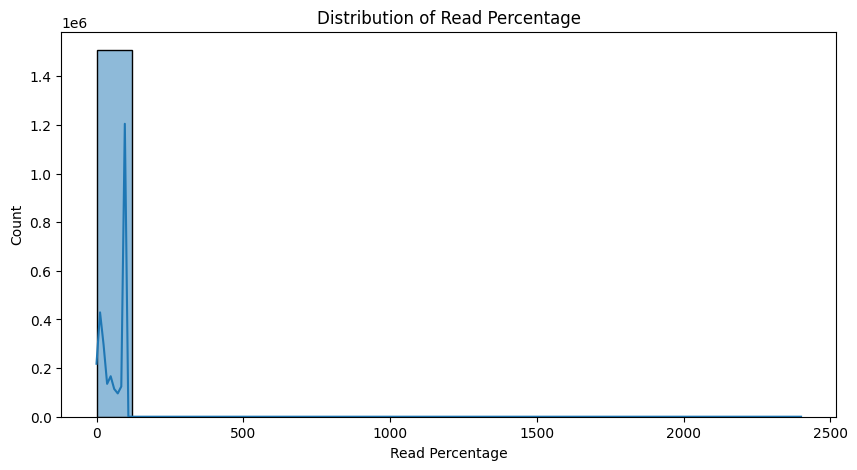

In [21]:
## Read Percentage Distributions
plt.figure(figsize=(10,5))
sns.histplot(final_df['read_percent'], bins=20, kde=True)
plt.title("Distribution of Read Percentage")
plt.xlabel("Read Percentage")
plt.ylabel("Count")
plt.show()

### **Key Observation**:
There are huge outliers that doesnt seems normal because as a `Read Percntage` the range of the reading should be betweent (0, 100)



In [22]:
print("Max Read Percentage:", final_df['read_percent'].max())
print("Min Read Percentage:", final_df['read_percent'].min())


Max Read Percentage: 2400.0
Min Read Percentage: 0.0


In [23]:
# Check how many values exceed 100%
outliers = final_df[final_df['read_percent'] > 100]
print("Number of Outliers:", len(outliers))
print(outliers[['user_id', 'pratilipi_id', 'read_percent']])

Number of Outliers: 22
                  user_id      pratilipi_id  read_percent
95313    5506791972061623  1377786216692750    125.000000
147378   5506791974012382   379249622685384    150.000000
241145   5506791968565716  1377786217740496    400.000000
409363   5506791961717276  1377786216901040    800.000000
470935   5506791952337656  1377786216853266    166.666667
517389   5506791957275784  1377786216288749    140.000000
543014   5506791955793066   581238512064200    120.000000
607833   5506791980188027  1377786216692750    133.333333
687799   5506791978673731  1377786216907065    800.000000
688537   5506791974357845   374669040064200    116.666667
721517   5506791984561687  1377786215441253    150.000000
747599   5506791955808076  1377786216901040    800.000000
827753   5506791961198220  1377786216288749    140.000000
846355   5506791947436627  1377786217520844    216.666667
902085   5506791991557562  1377786215834439    400.000000
994333   3708149573264036  1377786216901040   240

In [24]:
# Capping the values withn the range of (0, 100)
final_df['read_percent'] = final_df['read_percent'].clip(0, 100)

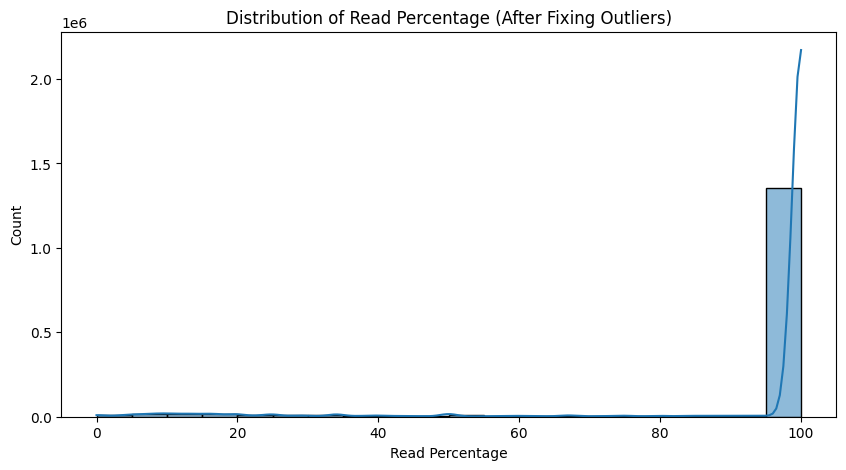

In [25]:
# Replotting to check for outliers
plt.figure(figsize=(10,5))
sns.histplot(final_df['read_percent'], bins=20, kde=True)
plt.title("Distribution of Read Percentage (After Fixing Outliers)")
plt.xlabel("Read Percentage")
plt.ylabel("Count")
plt.show()

### **Key Observation**:
1. **Majority of users finish the pratilipi (100%) or abandon early.**
    - Users who read fully might be more engaged and return to read similar content.

2. **Almost no mid-range engagement (20%-80%)**

## **Univaraite Analysis (Number of pratilipis per user)**

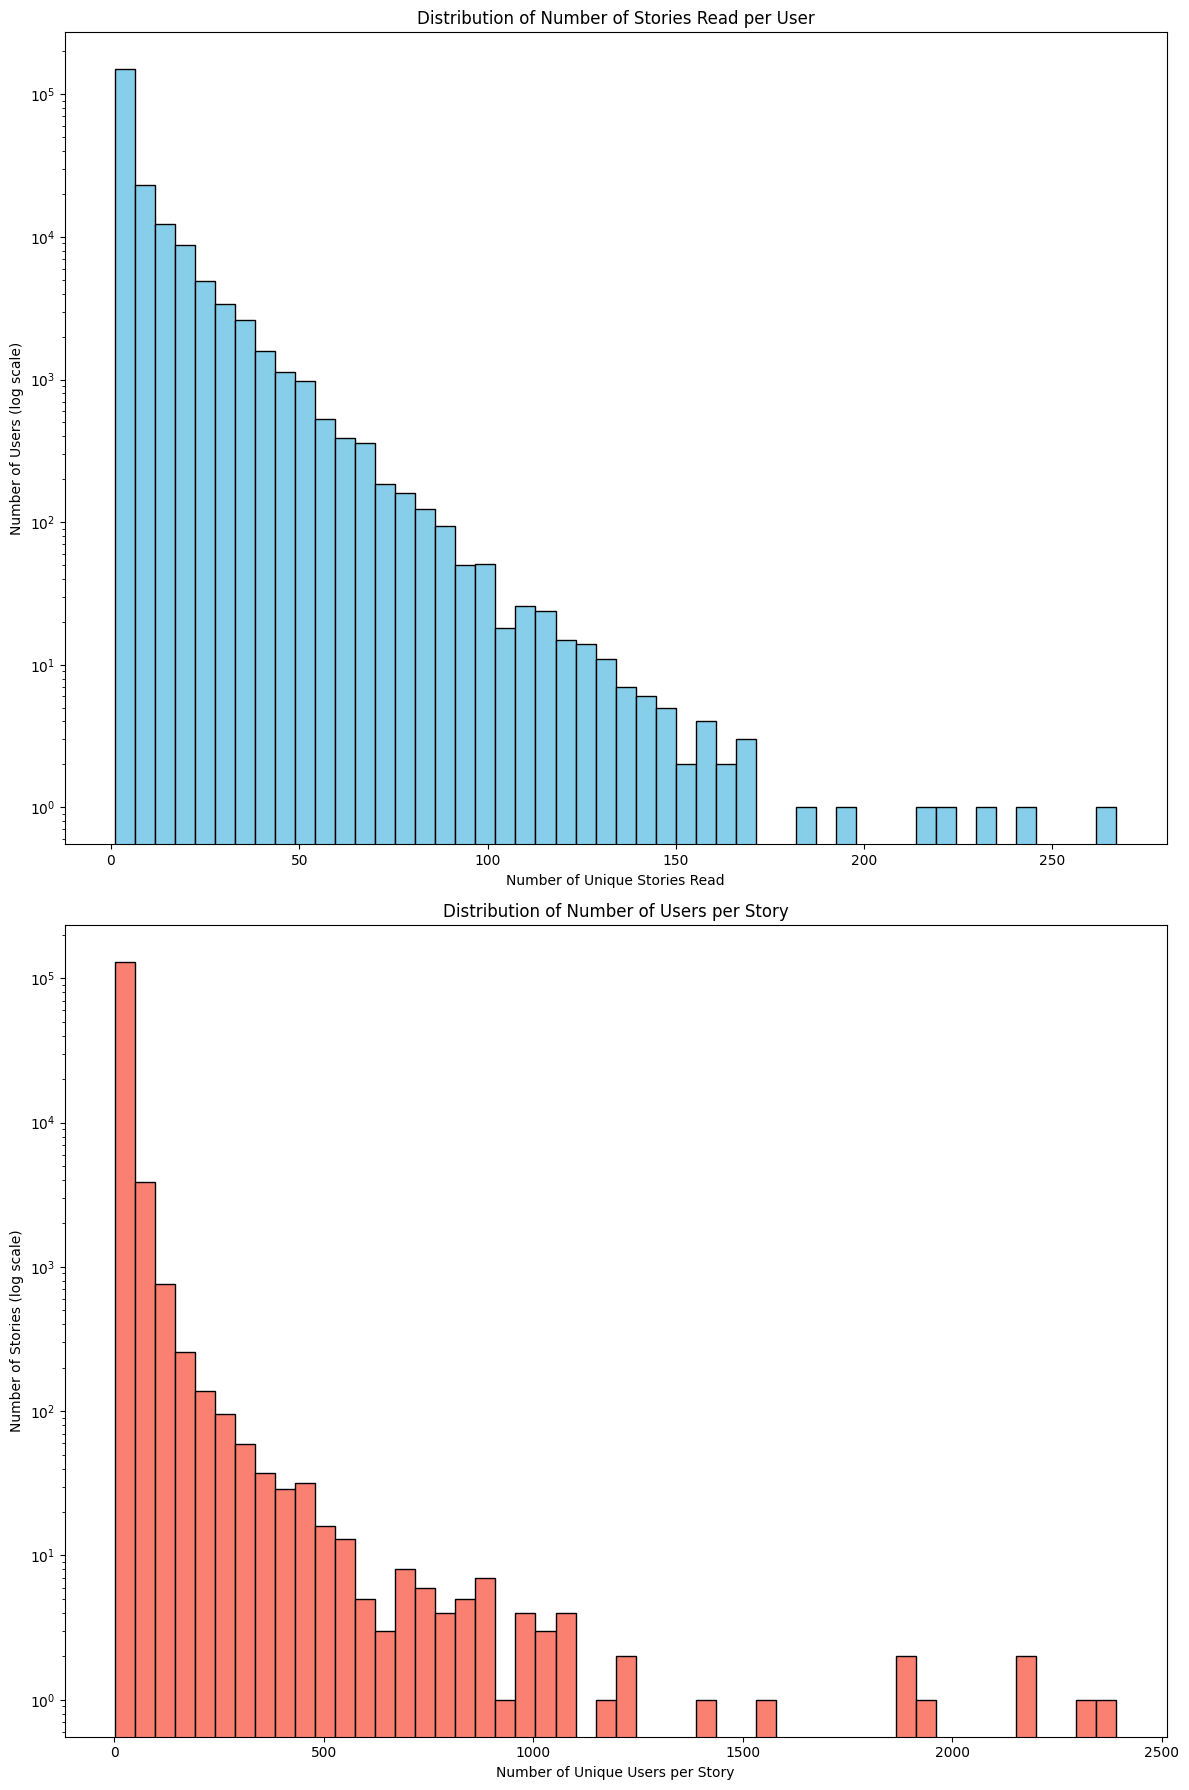

In [26]:
# 1. Number of stories per user (how many stories a typical user reads)
stories_per_user = final_df.groupby('user_id')['pratilipi_id'].nunique()

# 2. Number of users per story (how many users read each story)
users_per_story = final_df.groupby('pratilipi_id')['user_id'].nunique()


# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 18))

# Histogram for stories per user
axes[0].hist(stories_per_user, bins=50, color='skyblue', edgecolor='black', log=True)
axes[0].set_title('Distribution of Number of Stories Read per User')
axes[0].set_xlabel('Number of Unique Stories Read')
axes[0].set_ylabel('Number of Users (log scale)')

# Histogram for users per story
axes[1].hist(users_per_story, bins=50, color='salmon', edgecolor='black', log=True)
axes[1].set_title('Distribution of Number of Users per Story')
axes[1].set_xlabel('Number of Unique Users per Story')
axes[1].set_ylabel('Number of Stories (log scale)')

plt.tight_layout()
plt.show()


## **Insights**

1. **Distribution of Number of Stories Read per User**:
    - Highly Skewed Distribution: Most users read very few unique stories, while only a small fraction of users read a large number of stories.
    - Power-Law Behavior: A few users are highly engaged, consuming hundreds of stories, but the majority consume just a handful.

2. **Distribution of Number of Users per story**:
    - Long-Tail Distibution: A small number of stories are extremely popular, being read by thousands of users.
    

In [27]:
# Find stories (pratilipi_id) that have been read by the most users
popular_pratilipis = final_df['pratilipi_id'].value_counts().head(20)  # Top 20 most read pratilipis

# Convert to a DataFrame for better readability
popular_pratilipis_df = popular_pratilipis.reset_index()
popular_pratilipis_df.columns = ['pratilipi_id', 'num_users_read']

popular_pratilipis_df

,pratilipi_id,num_users_read
0,1377786217541698,2392
1,1377786228336060,2318
2,1377786228237359,2176
3,1377786228240538,2155
4,1377786228262109,1943
5,1377786228243389,1872
6,1377786215982409,1869
7,1377786217544226,1555
8,1377786228253938,1388
9,1377786228189551,1216


These are the `top 20` most read pratilipis

In [28]:
## Most engaged Users
user_activity = final_df.groupby('user_id').size().sort_values(ascending=False)
print("Top 10 Most Active Users")
print(user_activity.head(10))

Top 10 Most Active Users
user_id
5506791978555287    267
5506791984436689    242
5506791985959683    234
5371339105280676    224
5506791986650045    217
5506791966405805    197
5506791988639487    186
5506791994484810    170
5506791954021043    169
5506791964778551    168
dtype: int64


In [29]:
## Least engaged Users
print("10 least Active Users")
print(user_activity.tail(10))

10 least Active Users
user_id
5506791971779833    1
5506791971777884    1
5506791971776412    1
5506791971774197    1
5506791971770948    1
5506791971769646    1
5506791971769128    1
5506791971768561    1
5506791971768461    1
5506791996685385    1
dtype: int64


In [30]:
high_engagement_pratilipis = final_df[final_df['read_percent'] > 80]['pratilipi_id'].nunique()
low_engagement_pratilipis = final_df[final_df['read_percent'] < 20]['pratilipi_id'].nunique()

print(f"High-engagement Pratilipis (80%+ reads): {high_engagement_pratilipis}")
print(f"Low-engagement Pratilipis (<20% reads): {low_engagement_pratilipis}")

High-engagement Pratilipis (80%+ reads): 130027
Low-engagement Pratilipis (<20% reads): 26413


In [31]:
low_engagement_users = final_df[final_df['read_percent'] < 20]['user_id'].nunique()
print(f"Users who frequently quit early: {low_engagement_users}")

Users who frequently quit early: 39338


## **Univariate Analysis (Category_names)**

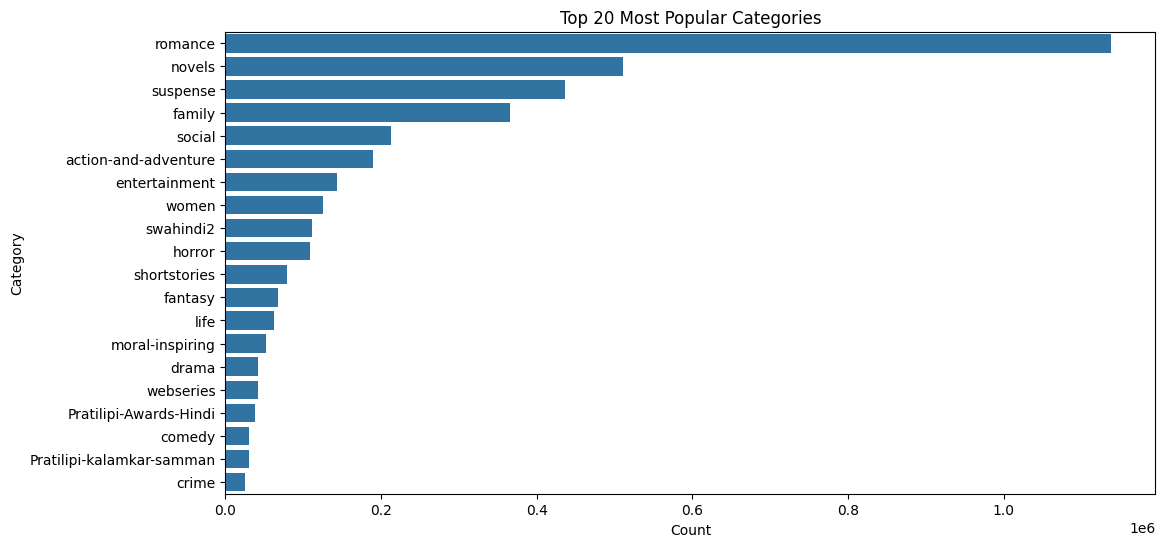

In [35]:
from collections import Counter

# Flatten category lists and count occurrences
all_categories = ', '.join(final_df['category_name'].dropna()).split(', ')
category_counts = Counter(all_categories)

# Convert to DataFrame for visualization
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count']).sort_values(by="Count", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="Count", y="Category", data=category_df.head(20))
plt.title("Top 20 Most Popular Categories")
plt.show()

## **Key Insights**:

- `Romance Dominates` - The "romance" category is by far the most popular, with significantly higher read counts than other categories.
- `Novels & Suspense` - These two genres also have a high engagement, meaning users prefer long-format storytelling with thrilling elements.
- `Family & Social Stories` Are Also Popular - Categories like family and social indicate that users also engage with stories that reflect relationships and societal themes.
- **Niche Genres** (Lower Counts) - Categories like `horror`, `swahindi2`, `women`, `entertainment` `shortstories`,`fantasy`,`life`,`moral-inspiring` have relatively lower engagement.

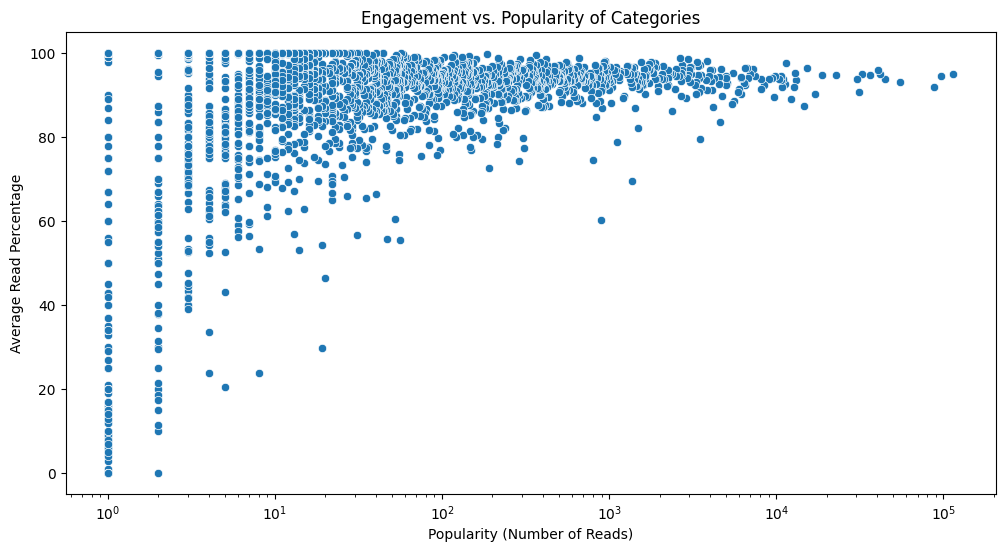

In [36]:
# Compute category popularity (how many times each category appears)
category_popularity = final_df['category_name'].value_counts().reset_index()
category_popularity.columns = ['category_name', 'popularity']

# Compute category engagement (average read percentage)
category_engagement = final_df.groupby('category_name')['read_percent'].mean().reset_index()
category_engagement.columns = ['category_name', 'avg_read_percent']

# Merge both metrics into a single DataFrame
category_analysis = category_popularity.merge(category_engagement, on='category_name')

# Plot scatter plot of engagement vs. popularity
plt.figure(figsize=(12, 6))
sns.scatterplot(data=category_analysis, x='popularity', y='avg_read_percent')

plt.xlabel("Popularity (Number of Reads)")
plt.ylabel("Average Read Percentage")
plt.title("Engagement vs. Popularity of Categories")
plt.xscale('log')  # Log scale for better visualization
plt.show()

## **Observation**:
- The majority of categories, regardless of popularity, have high average read percentages.
- On the left side (categories with fewer reads), engagement varies from 0% to 100%.
- As we move to the right (high popularity), engagement around 80-100%. This indicates that widely read categories maintain strong user engagement.
- A few points appear below 50%, indicating categories that are popular but not engaging.

In [37]:
category_analysis

,category_name,popularity,avg_read_percent
0,"family, romance, novels",114746,95.020325
1,"romance, suspense, novels",96967,94.525292
2,romance,88183,91.861739
3,"romance, novels",55269,93.128924
4,"romance, suspense",44662,93.926827
...,...,...,...
2991,"webseries, horror, swahindi2",1,100.000000
2992,"Parytan, moral-inspiring, short-story-challenge",1,100.000000
2993,"women, family, romance, moral-inspiring",1,89.000000
2994,"romance, suspense, Indiawale, crime, detective",1,100.000000


### **High engagement but low popularity content (Underrated content)**

In [38]:
# Define thresholds for high engagement and low popularity
high_engagement_threshold = 90  # Categories with avg_read_percent above 90%
low_popularity_threshold = category_analysis['popularity'].quantile(0.80)  

# Filter categories that meet the criteria
high_engagement_low_popularity = category_analysis[
    (category_analysis['avg_read_percent'] >= high_engagement_threshold) &
    (category_analysis['popularity'] <= low_popularity_threshold)
]


high_engagement_low_popularity.sort_values(by="popularity", ascending=False).head(20)

,category_name,popularity,avg_read_percent
599,"children, horror, suspense",130,92.284615
600,"romance, translation, short-story-challenge",129,95.441860
601,"family, action-and-adventure, novels",128,91.812500
602,"life, shortstories",127,92.818898
603,"swahindi2, detective, novels",125,96.352000
604,"science-fiction, suspense, swahindi2",125,90.136000
606,"social, life, Indiawale",124,93.050932
608,"romance, suspense, action-and-adventure, comedy",124,95.564516
609,"moral-inspiring, shortstories, comedy",124,91.846774
610,"shortstories, romance, Pratilipi-Awards-Hindi",122,95.131148


## **Insights**

- These categories have very high read percentages (often close to 100%) but have been read by a small number of users.
- `Suggestion` Since these categories resonate well with the few readers who discover them, they may benefit from better visibility.

### **Lets see the contents that are very popular but has less engagement**

In [39]:
# Define thresholds for low engagement and high popularity
low_engagement_threshold = 70  # Categories with avg_read_percent below 50%
high_popularity_threshold = category_analysis['popularity'].quantile(0.70)  

# Filter categories that meet the criteria
low_engagement_high_popularity = category_analysis[
    (category_analysis['avg_read_percent'] <= low_engagement_threshold) &
    (category_analysis['popularity'] >= high_popularity_threshold)
]

# Sort values by popularity in descending order
low_engagement_high_popularity.sort_values(by="popularity", ascending=False)

,category_name,popularity,avg_read_percent
158,"social, suspense, shortstories",1365,69.445665
204,"social, novels",895,60.349101
824,"women, webseries",56,55.553571
869,"crime-lekhan, romance, action-and-adventure",52,60.480769
900,"translation, moral-inspiring, novels",47,55.829787


## **Univariate Analysis(Authors)**

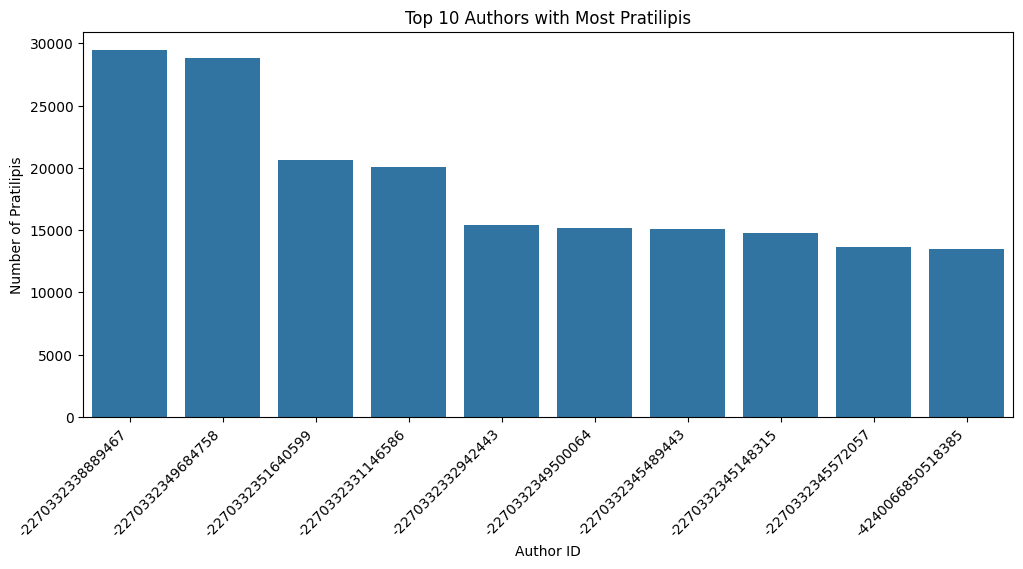

In [41]:
author_counts = final_df['author_id'].value_counts()

# Create a mapping of top 10 author IDs to categorical labels
top_authors = author_counts.head(10)


plt.figure(figsize=(12, 5))
sns.barplot(x=top_authors.index.astype(str), y=top_authors.values)
plt.title("Top 10 Authors with Most Pratilipis")
plt.xlabel("Author ID")
plt.ylabel("Number of Pratilipis")
plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
plt.show()



## **Insights**:

- Author -227032338889467 and -2270332349684758 have a significantly higher number of pratilipis nearly 30,000 each.
- The third and fourth top authors have around 20,000 pratilipis, showing a drop of 30% compared to the first two.
- From the fifth author onward, the count drops below 15,000.

### **Lets also check top authors also have higher reader engagement.**

In [42]:
# Get top 10 authors by the number of pratilipis
top_authors = final_df['author_id'].value_counts().head(10).index

# Filter data for only the top authors
top_authors_df = final_df[final_df['author_id'].isin(top_authors)]

# Compute average read percentage and reading time per author
author_engagement = top_authors_df.groupby('author_id').agg(
    avg_read_percent=('read_percent', 'mean'),
    avg_reading_time=('reading_time', 'mean'),
    num_stories=('pratilipi_id', 'nunique'),
    num_users=('user_id', 'nunique')  # Number of unique users reading their stories
).reset_index()

# Sort by average read percentage
author_engagement = author_engagement.sort_values(by='avg_read_percent', ascending=False)

author_engagement

,author_id,avg_read_percent,avg_reading_time,num_stories,num_users
1,-2270332332942443,97.776619,73.100325,2224,2398
7,-2270332349684758,97.088237,555.685739,177,8852
0,-2270332331146586,96.836037,464.811087,245,4364
5,-2270332345572057,96.625183,788.106410,279,4015
3,-2270332345148315,95.805097,744.269715,251,6147
2,-2270332338889467,95.226102,394.062765,841,5934
8,-2270332351640599,94.962442,552.057740,462,7739
9,-4240066850518385,94.271086,955.346710,618,4800
4,-2270332345489443,93.920143,1147.401937,125,5873
6,-2270332349500064,90.836903,975.339202,278,6611


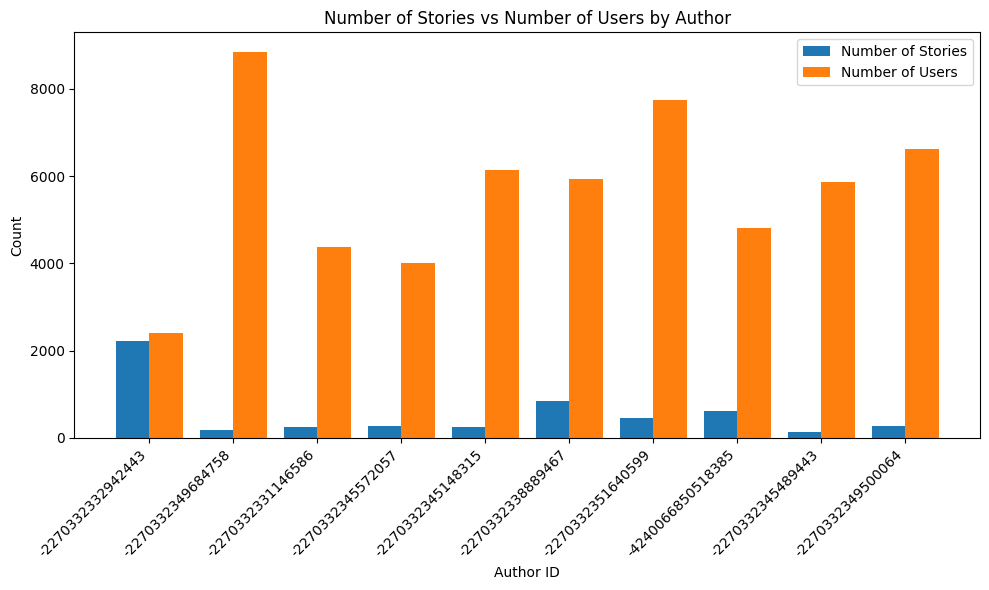

In [46]:
# Extract the numeric arrays
stories = author_engagement["num_stories"].values
users = author_engagement["num_users"].values

# x positions for each author
x = np.arange(len(author_engagement['author_id']))

plt.figure(figsize=(10, 6))
width = 0.4
# Plot the bars for number of stories (shift left by width/2)
plt.bar(x - width/2, stories, width=width, label="Number of Stories")
# Plot the bars for number of users (shift right by width/2)
plt.bar(x + width/2, users, width=width, label="Number of Users")

plt.xlabel("Author ID")
plt.ylabel("Count")
plt.title("Number of Stories vs Number of Users by Author")

# Replace default tick positions/labels with the author string IDs
plt.xticks(x, author_engagement['author_id'], rotation=45, ha="right")

plt.legend()
plt.tight_layout()
plt.show()


## **Insights**

- Most authors in this list have over 90% average read percentage, meaning users fully engage with their stories.
- Some authors have very high reading time 
- Others have shorter but more widely read stories (e.g., 73 mins for -2270332332924443).
- The first author (-2270332332924443) has 2,224 stories, the highest among the top authors. but comparatively has the least users
- Other authors have much fewer stories but higher reader engagement (e.g., -2270332349500064 with 278 stories but 975 avg reading time).This shows that quality vs. quantity varies for engagement.
- Some authors have large audiences (e.g., -2270332349684758 has 8,852 unique users)

## **Univariate analysis (Reading Time)**

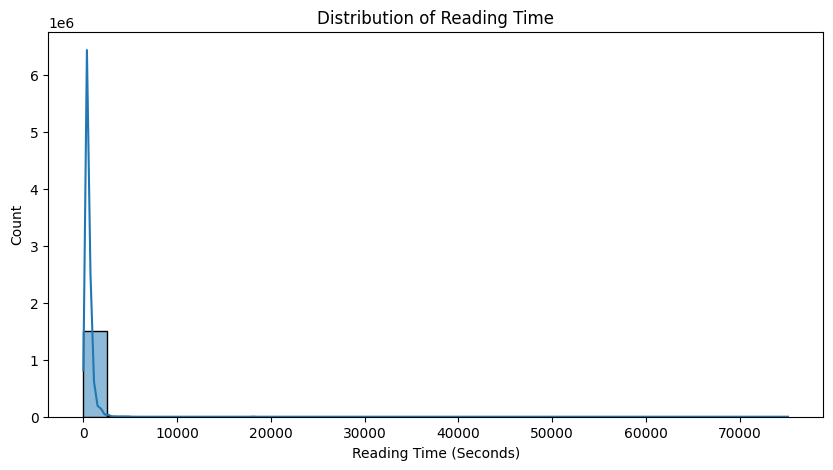

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(final_df['reading_time'], bins=30, kde=True)
plt.title("Distribution of Reading Time")
plt.xlabel("Reading Time (Seconds)")
plt.ylabel("Count")
plt.show()

## **Insights**
- most stories are short or users prefer reading shorter content.
- The presence of long reading time outliers suggests that some stories are significantly longer.

### **Lets Analyze reading time by category**

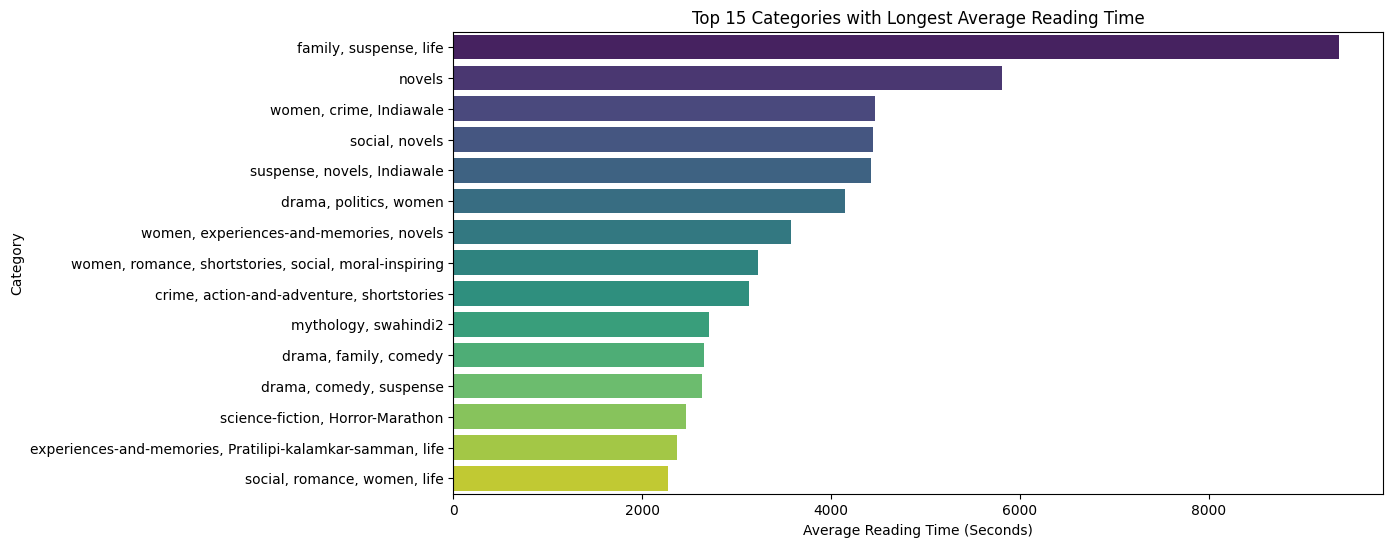

In [ ]:
# Step 1: Analyze reading time by category
category_reading_time = final_df.groupby('category_name')['reading_time'].mean().sort_values(ascending=False)

# Step 2: Identify Pratilipis with unusually high reading times (top 1% outliers)
threshold = final_df['reading_time'].quantile(0.99)  # 99th percentile
high_reading_time_pratilipis = final_df[final_df['reading_time'] >= threshold]

# Step 3: Visualize top 15 categories with the highest average reading time
plt.figure(figsize=(12, 6))
sns.barplot(y=category_reading_time.head(15).index, x=category_reading_time.head(15).values, palette="viridis")
plt.xlabel("Average Reading Time (Seconds)")
plt.ylabel("Category")
plt.title("Top 15 Categories with Longest Average Reading Time")
plt.show()


## **Insights**
- The category "life, family, suspense" has the longest average reading time, significantly higher than others, suggesting it includes longer, more immersive stories.
- Categories that involve deep storytelling, such as "Indiawale, women, crime" and "novels, social", indicate that crime and social themes may contribute to longer reading times.
- Some hybrid categories like "science-fiction, Horror-Marathon", "action-and-adventure, crime, short stories", and "drama, comedy, suspense" indicate that multi-genre stories also contribute to extended engagement.
- Categories like "life, experiences-and-memories, Pratilipi-kalamkar-samman" and "swahindi2, mythology" appearing on this list suggest niche audiences deeply engage with them.


### **Lets check popularty based on Reading time**

In [ ]:
# Assuming final_df is the dataset loaded
df = final_df.copy()

# Compute popularity metrics
pratilipi_popularity = df.groupby("pratilipi_id").agg(
    num_reads=("user_id", "count"),        # Total reads per pratilipi
    num_users=("user_id", "nunique"),      # Unique users per pratilipi
    avg_read_percent=("read_percent", "mean"), # Average read percentage per pratilipi
    avg_reading_time=("reading_time", "mean")  # Average reading time per pratilipi
).reset_index()

pratilipi_popularity.head()

,pratilipi_id,num_reads,num_users,avg_read_percent,avg_reading_time
0,-104396726036792,2,2,100.0,10445.0
1,-104716277999928,2,2,100.0,256.0
2,-105402708879672,2,2,100.0,61.0
3,-10922210191672,1,1,13.0,3291.0
4,-109830333622584,3,3,100.0,121.0


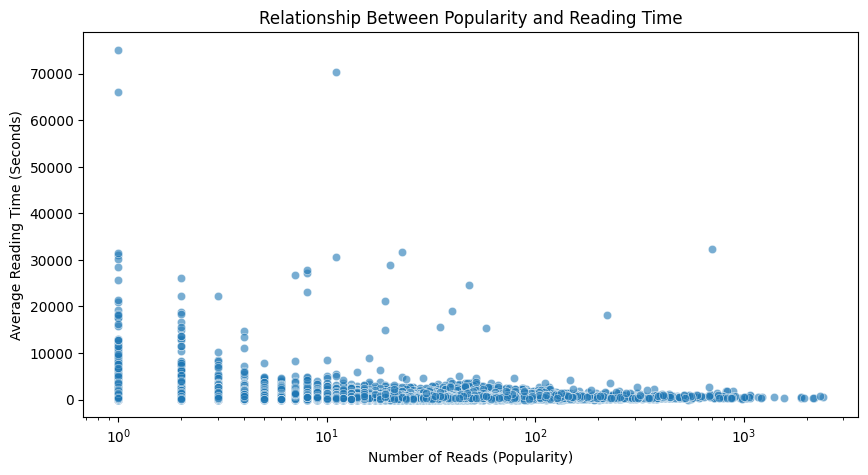

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=pratilipi_popularity["num_reads"], y=pratilipi_popularity["avg_reading_time"], alpha=0.6)

plt.xscale("log")  # Log scale to handle wide range of values
plt.xlabel("Number of Reads (Popularity)")
plt.ylabel("Average Reading Time (Seconds)")
plt.title("Relationship Between Popularity and Reading Time")

plt.show()

## **Insights**
- The majority of highly popular Pratilipis (those with a high number of reads) tend to have lower average reading times, suggesting that shorter content (less than 10000 sec reading time) may attract more readers.
- A significant number of Pratilipis have very few reads (left side of the plot), yet their reading times vary widely.

## **Univariate analysis (Updated_at)**

In [ ]:
# Convert to datetime
final_df['updated_at'] = pd.to_datetime(final_df['updated_at'])

# Extract useful time-based features
final_df['updated_year'] = final_df['updated_at'].dt.year
final_df['updated_month'] = final_df['updated_at'].dt.month
final_df['updated_day'] = final_df['updated_at'].dt.day_name()
final_df['updated_hour'] = final_df['updated_at'].dt.hour

### **Lets see the peak reading times**

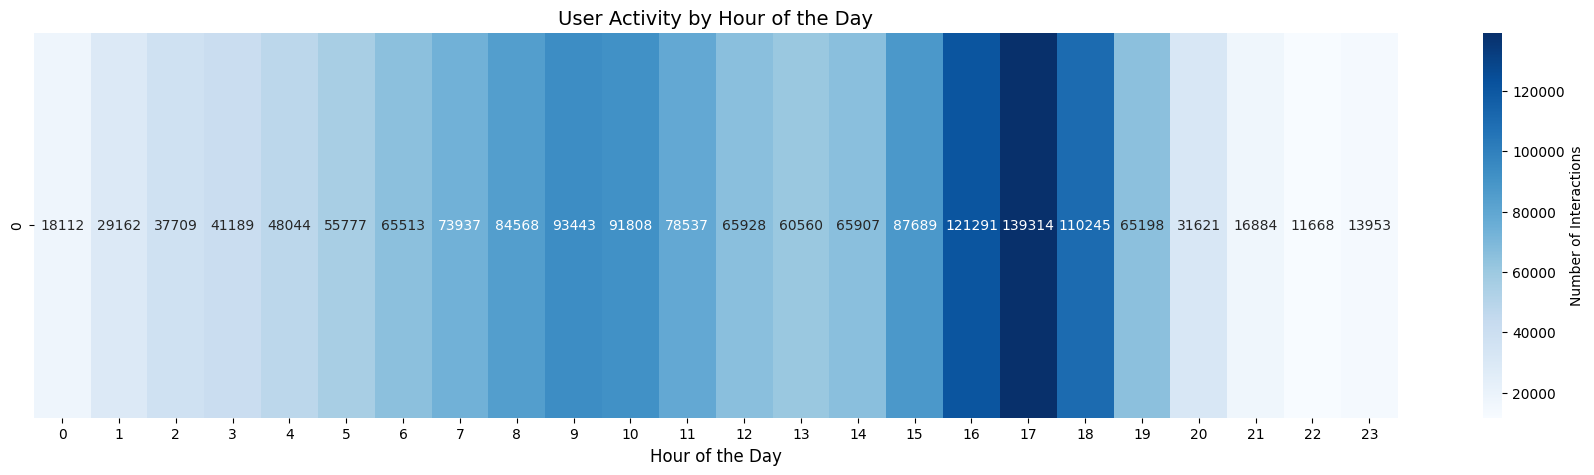

In [ ]:
# Count occurrences per hour
hourly_activity = final_df['updated_hour'].value_counts().sort_index()

# Plot the heatmap
plt.figure(figsize=(22,5))  # Increase figure size
sns.heatmap(hourly_activity.values.reshape(1, -1), cmap="Blues", annot=True, fmt=".0f", xticklabels=hourly_activity.index, cbar_kws={'label': 'Number of Interactions'})

# Formatting
plt.xlabel("Hour of the Day", fontsize=12)
plt.title("User Activity by Hour of the Day", fontsize=14)
plt.show()

## **Insights**
- The highest user activity occurs between 4 PM to 6 PM, with the peak at 5 PM (17:00).This could indicate that users prefer to engage with Pratilipi content in the late afternoon and early evening.
- There is a steep decline in activity from 10 PM (22:00) onwards, reaching the lowest points between midnight (00:00) and 6 AM.
- There is a slight dip in activity around lunchtime (12 PM - 2 PM) before picking up again in the afternoon.

## **Lets check the Published_at columns**

In [ ]:
final_df['published_year'] = final_df['published_at'].dt.year

### **lets check read_percent based on published date (old or new)**

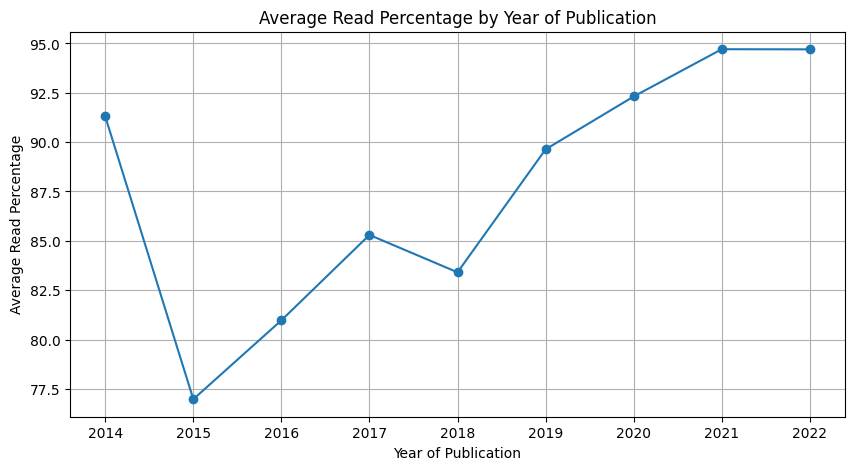

In [ ]:
# Calculate average read percentage per year
yearly_read_percent = final_df.groupby('published_year')['read_percent'].mean().dropna()

# Plot
plt.figure(figsize=(10,5))
plt.plot(yearly_read_percent.index, yearly_read_percent.values, marker='o', linestyle='-')
plt.xlabel("Year of Publication")
plt.ylabel("Average Read Percentage")
plt.title("Average Read Percentage by Year of Publication")
plt.grid(True)
plt.show()


## **Insights**
- The highest average read percentage is observed in 2021 and 2022, where it reaches around 95%. This indicates that newer content is more engaging to readers.
- In 2015, there was a dip in the average read percentage, dropping to the lowest point (77%)
- The sharpest increase happened between 2018 and 2019, where the average read percentage jumped from 83% to 90%.
-From 2019 onwards, the read percentage consistently increased year over year, showing that more recent content has been well-received.

### **Lets check the popularity base on published year(old or new)**

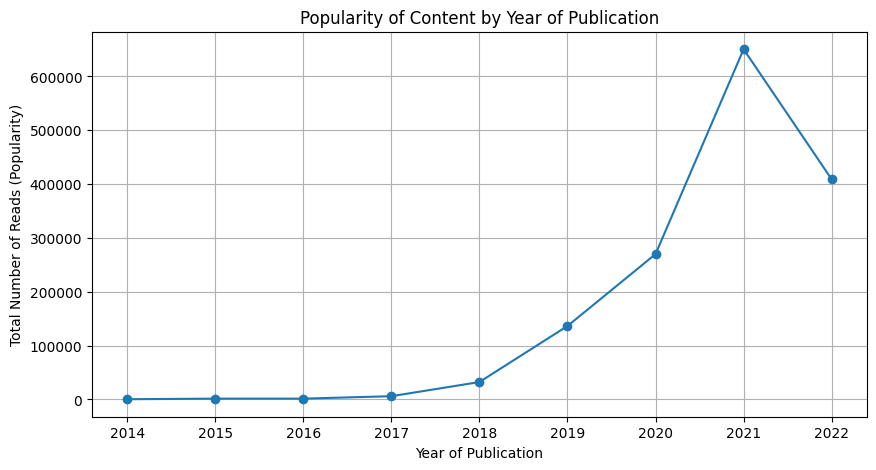

In [ ]:
# Group by publication year and calculate total number of reads (popularity)
popularity_by_year = final_df.groupby('published_year')['pratilipi_id'].count()

# Plot the trend of popularity over the years
plt.figure(figsize=(10, 5))
plt.plot(popularity_by_year.index, popularity_by_year.values, marker='o', linestyle='-')

# Formatting
plt.xlabel("Year of Publication")
plt.ylabel("Total Number of Reads (Popularity)")
plt.title("Popularity of Content by Year of Publication")
plt.grid(True)

# Show the plot
plt.show()

## **Insights**
- The number of reads increased significantly from 2018 onwards, reaching its peak in 2021.
- After the peak in 2021, the popularity dropped in 2022.
- Pratilipis published before 2018 have significantly fewer total reads. Older content may not be receiving much engagement, likely due to a shift in user interests or limited discoverability.

In [ ]:
final_df.head()

,user_id,pratilipi_id,read_percent,updated_at,author_id,category_name,reading_time,published_at,updated_year,updated_month,updated_day,updated_hour,published_year
0,5506791961876448,1377786228262109,100.0,2022-03-22 10:29:57.291,-2270332349684758,"romance, family, novels",376,2022-03-15 18:39:52,2022,3,Tuesday,10,2022
1,5506791971543560,1377786223038206,40.0,2022-03-19 13:49:25.660,-2270332348374323,"romance, suspense",361,2021-03-16 19:09:19,2022,3,Saturday,13,2021
2,5506791996468218,1377786227025240,100.0,2022-03-21 17:28:47.288,-2270332332674531,romance,582,2021-12-29 13:31:30,2022,3,Monday,17,2021
3,5506791978752866,1377786222398208,65.0,2022-03-21 07:39:25.183,-2270332332880683,"romance, action-and-adventure, webseries",1451,2021-01-21 13:55:52,2022,3,Monday,7,2021
4,5506791978962946,1377786228157051,100.0,2022-03-22 17:32:44.777,-2270332331146586,"romance, swahindi2, suspense",811,2022-03-08 16:31:41,2022,3,Tuesday,17,2022


### **Lets remove the unnecessary features**
- Dropping the features that will not come handy for our collaborative recommendation system.



In [ ]:
dropping_columns = ['updated_at','author_id','published_at','updated_year','updated_month','updated_day','updated_hour','published_year']
final_df.drop(columns=dropping_columns,inplace=True)

In [ ]:
final_df

,user_id,pratilipi_id,read_percent,category_name,reading_time
0,5506791961876448,1377786228262109,100.0,"romance, family, novels",376
1,5506791971543560,1377786223038206,40.0,"romance, suspense",361
2,5506791996468218,1377786227025240,100.0,romance,582
3,5506791978752866,1377786222398208,65.0,"romance, action-and-adventure, webseries",1451
4,5506791978962946,1377786228157051,100.0,"romance, swahindi2, suspense",811
...,...,...,...,...,...
1508052,5506791954810282,1377786227368960,100.0,"social, romance, swahindi2",376
1508053,5506791966125995,1377786221431279,100.0,romance,1157
1508054,5506791964496442,1377786226829597,100.0,"romance, action-and-adventure, suspense",392
1508055,5506791968781083,1377786226056467,100.0,"romance, novels, suspense",560


### **Popularity Based Recommendation system**

- The Criteria is based on:
    - Pratilipis read percentage (ratings)
    - Number of Reads

In [ ]:
final_df.head()

,user_id,pratilipi_id,read_percent,category_name,reading_time
0,5506791961876448,1377786228262109,100.0,"romance, family, novels",376
1,5506791971543560,1377786223038206,40.0,"romance, suspense",361
2,5506791996468218,1377786227025240,100.0,romance,582
3,5506791978752866,1377786222398208,65.0,"romance, action-and-adventure, webseries",1451
4,5506791978962946,1377786228157051,100.0,"romance, swahindi2, suspense",811


### **Average Ratings of Pratilipis**


In [ ]:
popularity_df = final_df.copy()

popularity_df.groupby('pratilipi_id')['read_percent'].mean().head()

pratilipi_id
-104396726036792    100.0
-104716277999928    100.0
-105402708879672    100.0
-10922210191672      13.0
-109830333622584    100.0
Name: read_percent, dtype: float64

In [ ]:
popularity_df.groupby('pratilipi_id')['read_percent'].mean().sort_values(ascending=False).head(10)

pratilipi_id
-104396726036792    100.0
1377786224085201    100.0
1377786224087617    100.0
1377786224087437    100.0
1377786224087319    100.0
1377786224087173    100.0
1377786224086578    100.0
1377786224086121    100.0
1377786224086118    100.0
1377786224085465    100.0
Name: read_percent, dtype: float64

In [ ]:
popularity_df.groupby('pratilipi_id')['read_percent'].mean().sort_values(ascending=False).tail(10)

pratilipi_id
1377786228351031    0.0
1377786228234176    0.0
1377786218893717    0.0
1377786228350822    0.0
1377786228306162    0.0
1377786228337877    0.0
1377786228337967    0.0
1377786217658911    0.0
1377786228306434    0.0
1377786228325605    0.0
Name: read_percent, dtype: float64

### **Ratings Count**

In [ ]:
popularity_df.groupby('pratilipi_id')['read_percent'].count().sort_values(ascending=False).head(10)

pratilipi_id
1377786217541698    2392
1377786228336060    2318
1377786228237359    2176
1377786228240538    2155
1377786228262109    1943
1377786228243389    1872
1377786215982409    1869
1377786217544226    1555
1377786228253938    1388
1377786228189551    1216
Name: read_percent, dtype: int64

### **Lets combine and now see the ratings based on reads**

In [ ]:
reading_percent_count = pd.DataFrame(popularity_df.groupby('pratilipi_id')['read_percent'].mean())
reading_percent_count

,read_percent
pratilipi_id,
-104396726036792,100.0
-104716277999928,100.0
-105402708879672,100.0
-10922210191672,13.0
-109830333622584,100.0
...,...
997646789154504,100.0
998502116792008,100.0
998703514162888,100.0


### **Calculate count of the readings and add the average reading**

In [ ]:
reading_percent_count['reading_counts'] = pd.DataFrame(popularity_df.groupby('pratilipi_id')['read_percent'].count())

In [ ]:
reading_percent_count['read_percent'] = round(reading_percent_count['read_percent'],1)

In [ ]:
reading_percent_count.head()

,read_percent,reading_counts
pratilipi_id,,
-104396726036792,100.0,2
-104716277999928,100.0,2
-105402708879672,100.0,2
-10922210191672,13.0,1
-109830333622584,100.0,3


### **Now lets setup the criteria for a pratilipis to be a popular**

- Lets say if the pratilipis read percent is more than 60% it means the reader isliking a lot.
- And also that particular pratilipi must have more than certain number of reads to become popular lets say more than 600 reads

## **These are the TOP 10 Pratilipis**

In [ ]:
reading_percent_count = reading_percent_count[(reading_percent_count['read_percent'] > 80) & (reading_percent_count['reading_counts']>600)]
reading_percent_count.sort_values(by='read_percent', ascending=False).head(10)

,read_percent,reading_counts
pratilipi_id,,
1377786228227774,99.2,719
1377786228240538,98.7,2155
1377786228237359,98.4,2176
1377786228274181,98.0,756
1377786228262109,97.9,1943
1377786228210136,97.8,837
1377786228235724,97.8,858
1377786228220763,97.7,643
1377786228250424,97.7,876


## **Classification-based Collaborative Recommendation system**

1. User-user Collaborative filtering
2. item - item collaborative filtering

So basically the task was to predict future reading behavior.

Instead of predicting a continuous read percentage (regression), we can classify whether a user is likely (1) or not likely (0) to read a pratilipi.

## **Train Test Split**

In [ ]:
final_df.head()

,user_id,pratilipi_id,read_percent,category_name,reading_time
0,5506791961876448,1377786228262109,100.0,"romance, family, novels",376
1,5506791971543560,1377786223038206,40.0,"romance, suspense",361
2,5506791996468218,1377786227025240,100.0,romance,582
3,5506791978752866,1377786222398208,65.0,"romance, action-and-adventure, webseries",1451
4,5506791978962946,1377786228157051,100.0,"romance, swahindi2, suspense",811


In [ ]:
# X_train and X_test split
X_train, X_test = train_test_split(final_df, test_size=0.25, random_state=42)

## **Lets Check the Cold start Issue**

In [ ]:
pratilipi_overlap = X_test['pratilipi_id'].isin(X_train['pratilipi_id']).mean()
user_overlap = X_test['user_id'].isin(X_train['user_id']).mean()

print(f"Pratilipi Overlap: {pratilipi_overlap*100:.2f}%")
print(f"User Overlap: {user_overlap*100:.2f}%")


Pratilipi Overlap: 96.72%
User Overlap: 93.97%


### **Cold start issue**
- like most of the data are present in both train and test set only some of them are not present therefore it will not be a severe issue 

In [ ]:
# Identify users and pratilipis present in training data
train_users = set(X_train['user_id'])
train_pratilipis = set(X_train['pratilipi_id'])

# Filter test set to keep only seen users and pratilipis
X_test_filtered = X_test[X_test['user_id'].isin(train_users) & X_test['pratilipi_id'].isin(train_pratilipis)]

print(f"Original Test Set Size: {len(X_test)}")
print(f"Filtered Test Set Size: {len(X_test_filtered)}")

Original Test Set Size: 377015
Filtered Test Set Size: 342777


In [ ]:
pratilipi_overlap = X_test_filtered['pratilipi_id'].isin(X_train['pratilipi_id']).mean()
user_overlap = X_test_filtered['user_id'].isin(X_train['user_id']).mean()

print(f"Pratilipi Overlap: {pratilipi_overlap*100:.2f}%")
print(f"User Overlap: {user_overlap*100:.2f}%")

Pratilipi Overlap: 100.00%
User Overlap: 100.00%


### Now lets set a Threshold to classify if a user either reads (1) or not (0)

In [ ]:
X_train['read_label'] = (X_train['read_percent'] >= 60).astype(int)
X_test_filtered['read_label'] = (X_test_filtered['read_percent'] >= 60).astype(int)

y_train = X_train['read_label']
y_test = X_test_filtered['read_label']

In [ ]:
y_train.value_counts()

read_label
1    1043646
0      87396
Name: count, dtype: int64

if i take threshold as 60 the dataset becomes too imbalanced we can use SMOTE for Oversampling the data

In [ ]:
X_train = X_train.drop(columns=['read_percent','read_label'])
X_test_filtered = X_test_filtered.drop(columns=['read_percent','read_label'])

In [ ]:
X_train.head()

,user_id,pratilipi_id,category_name,reading_time
1205891,5506791957368478,1377786218912589,"romance, action-and-adventure, novels",871
1378671,5506791964986014,1377786222879127,"romance, novels, fantasy",30
172214,5506791963820766,1377786226874439,romance,804
1316531,5506791955412219,1377786227282577,"romance, family, social",642
1418645,5506791994425255,1377786219465510,entertainment,365


## **Feature Engineering**

- `User_id` and `pratilipi_id` (**Label encoder**)
    - because user_id and pratilipi_id may llook like bunch of integers but they are treated as categories.

- `Category_name` (**Multi-Label categorical columns**)
    - Since category_name contains multiple genres per row (e.g "romance, fantasy, novels"), we need multi-hot encoding or TF-IDF encoding.

- `reading_time` (**Min_Max Scaling**)
    - Since it is a numerical feature,

`User_id` and `pratilipi_id`

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode user_id and pratilipi_id
user_encoder = LabelEncoder()
pratilipi_encoder = LabelEncoder()

X_train['user_id'] = user_encoder.fit_transform(X_train['user_id'])
X_train['pratilipi_id'] = pratilipi_encoder.fit_transform(X_train['pratilipi_id'])

X_test_filtered['user_id'] = user_encoder.transform(X_test_filtered['user_id'])
X_test_filtered['pratilipi_id'] = pratilipi_encoder.transform(X_test_filtered['pratilipi_id'])



`category_name` 

In [ ]:
import re

# Convert to lowercase
X_train['category_name'] = X_train['category_name'].str.lower()
X_test_filtered['category_name'] = X_test_filtered['category_name'].str.lower()

# Remove 'and' from category names
X_train['category_name'] = X_train['category_name'].str.replace(r'\band\b', '', regex=True)
X_test_filtered['category_name'] = X_test_filtered['category_name'].str.replace(r'\band\b', '', regex=True)

# Replace special characters (like "-") with spaces before removing others
X_train['category_name'] = X_train['category_name'].apply(lambda x: re.sub(r'[-]', ' ', x))
X_test_filtered['category_name'] = X_test_filtered['category_name'].apply(lambda x: re.sub(r'[-]', ' ', x))

# Remove remaining special characters (except spaces)
X_train['category_name'] = X_train['category_name'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
X_test_filtered['category_name'] = X_test_filtered['category_name'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Replace multiple spaces with a single space and trim spaces
X_train['category_name'] = X_train['category_name'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
X_test_filtered['category_name'] = X_test_filtered['category_name'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Verify cleaned category names
print(X_train['category_name'].head())


1205891    romance action adventure novels
1378671             romance novels fantasy
172214                             romance
1316531              romance family social
1418645                      entertainment
Name: category_name, dtype: object


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of categories to a string format
X_train['category_str'] = X_train['category_name'].apply(lambda x: ' '.join(x.split(', ')))
X_test_filtered['category_str'] = X_test_filtered['category_name'].apply(lambda x: ' '.join(x.split(', ')))

# Apply CountVectorizer for one-hot encoding
vectorizer = CountVectorizer()
category_train_encoded = vectorizer.fit_transform(X_train['category_str']).toarray()
category_test_encoded = vectorizer.transform(X_test_filtered['category_str']).toarray()

# Convert to DataFrame
category_train_df = pd.DataFrame(category_train_encoded, columns=vectorizer.get_feature_names_out())
category_test_df = pd.DataFrame(category_test_encoded, columns=vectorizer.get_feature_names_out())

# Concatenate the encoded categories back
X_train = X_train.reset_index(drop=True)
X_test_filtered = X_test_filtered.reset_index(drop=True)

X_train = pd.concat([X_train, category_train_df], axis=1)
X_test_filtered = pd.concat([X_test_filtered, category_test_df], axis=1)

# Drop original category_name and category_str columns
X_train.drop(columns=['category_name', 'category_str'], inplace=True)
X_test_filtered.drop(columns=['category_name', 'category_str'], inplace=True)


In [ ]:
X_train.head()

,user_id,pratilipi_id,reading_time,action,adventure,awards,challenge,chat,children,comedy,...,social,spiritual,story,suspense,swahindi,the,translation,webseries,wellness,women
0,41196,22716,871,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,73897,54549,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65409,101315,804,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34416,106469,642,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,165446,25884,365,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`reading_time` scaling  with minmaxscaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train['reading_time'] = scaler.fit_transform(X_train[['reading_time']])
X_test_filtered['reading_time'] = scaler.transform(X_test_filtered[['reading_time']])

### **Apply SMOTE (Over sampling) and RandomUnderSampler (Under sampling) to handle Imbalance**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Applying SMOTE for Oversampling the minority class
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Minority class will be 50% of majority class
X_over, y_over = smote.fit_resample(X_train, y_train)

# Applying Random UnderSampling to reduce the majority class
under = RandomUnderSampler(sampling_strategy=1, random_state=42)  # Majority class reduced to 80% of its original
X_train_balanced, y_train_balanced = under.fit_resample(X_over, y_over)

# Check the new class distribution
print("Before Balancing:", y_train.value_counts())
print("After OverSampling:", y_over.value_counts())
print("After UnderSampling:", y_train_balanced.value_counts())

Before Balancing: read_label
1    1043646
0      87396
Name: count, dtype: int64
After OverSampling: read_label
1    1043646
0     521823
Name: count, dtype: int64
After UnderSampling: read_label
0    521823
1    521823
Name: count, dtype: int64


Removing `user_id` and `pratilipi_id` as it doesnt have any impact on the model.

In [ ]:
X_train_balanced = X_train_balanced.drop(columns = ['user_id','pratilipi_id'])
X_test_filtered = X_test_filtered.drop(columns=['user_id','pratilipi_id'])

### **Model Training**

- We will make a model training pipeline to effeciently train our model


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## Creating a function that will evaluate model
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return acc, report, cm, roc_auc

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Utilising different models to see their base scores.
models = {
    'Logistic Regression': LogisticRegression(),
    'XGB Classifier': XGBClassifier(objective= 'reg:logistic',learning_rate= 0.01, gamma=0)
    }

model_list = []
acc_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_balanced, y_train_balanced) # Train Model

    # Make Predictions
    y_train_pred = model.predict(X_train_balanced)
    y_test_pred = model.predict(X_test_filtered)

     #Evaluate Train and Test Dataset (evaluating with both train and test dependent variables are important to check if the model is overfitting or not.)
    model_train_acc_score, model_train_classification, model_train_confusion, model_train_roc_auc = evaluate_model(y_train_balanced, y_train_pred)

    model_test_acc_score, model_test_classification, model_test_confusion, model_test_roc_auc = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    

    print("Model Performance for Training Set")
    print(f'- ROC_AUC score: {model_train_roc_auc}')
    print(f'- Accuracy score: {model_train_acc_score}')
    print(f'- Classification Report: {model_train_classification}')
    print(f'- Confusion matrix: {model_train_confusion}')

    print('------------------------------------------------------------------------')

    print("Model Performance for Testing Set")
    print(f'- ROC_AUC score: {model_test_roc_auc}')
    print(f'- Accuracy score: {model_test_acc_score}')
    print(f'- Classification Report: {model_test_classification}')
    print(f'- Confusion Matrix: {model_test_confusion}')

    acc_list.append(model_test_acc_score)

    print('='*50)
    print('\n')


Logistic Regression
Model Performance for Training Set
- ROC_AUC score: 0.7963495284799635
- Accuracy score: 0.7963495284799635
- Classification Report:               precision    recall  f1-score   support

           0       0.79      0.80      0.80    521823
           1       0.80      0.79      0.79    521823

    accuracy                           0.80   1043646
   macro avg       0.80      0.80      0.80   1043646
weighted avg       0.80      0.80      0.80   1043646

- Confusion matrix: [[419047 102776]
 [109763 412060]]
------------------------------------------------------------------------
Model Performance for Testing Set
- ROC_AUC score: 0.52485057059539
- Accuracy score: 0.7643015721591588
- Classification Report:               precision    recall  f1-score   support

           0       0.08      0.25      0.12     23046
           1       0.94      0.80      0.86    319731

    accuracy                           0.76    342777
   macro avg       0.51      0.52      0.49 

## **Insights**

1. **Train set Performance**:
    - Logistic Regression ROC-AUC: 0.796 (Good)
    - XGBoost ROC-AUC: 0.767 (Slightly lower but still reasonable)
    - Both models  have balanced precision, recall, and f1-scores due to SMOTE.

2. **Test set Performance**:
    - Logistic Regression ROC-AUC: 0.524 (Low)
    - XGBoost ROC-AUC: 0.539 (Slightly better)
    - Poor precision for class 0 (users who don't read). The model still favors "1" due to oversampling effects.

## **Neural Collaborative Filtering**

In [ ]:
# X_train and X_test split
train_df, test_df = train_test_split(final_df, test_size=0.25, random_state=42)

### **Treating Cold start Issues**

In [ ]:
# Identify users and pratilipis present in training data
train_users = set(train_df['user_id'])
train_pratilipis = set(train_df['pratilipi_id'])

# Filter test set to keep only seen users and pratilipis
test_filtered = test_df[test_df['user_id'].isin(train_users) & X_test['pratilipi_id'].isin(train_pratilipis)]

print(f"Original Test Set Size: {len(test_df)}")
print(f"Filtered Test Set Size: {len(test_filtered)}")

Original Test Set Size: 377015
Filtered Test Set Size: 342777


### **Setting up a threshold wether if a user reads or not**

In [ ]:
train_df['read_label'] = (train_df['read_percent'] > 60).astype(int)
test_filtered['read_label'] = (test_filtered['read_percent'] > 60).astype(int)

train_y = train_df['read_label']
test_y = test_filtered['read_label']

# Dropping the read_percent columns and the read_label columns
train_df = train_df.drop(columns=['read_percent','read_label'])
test_filtered = test_filtered.drop(columns=['read_percent','read_label'])

In [ ]:
train_df.head()

,user_id,pratilipi_id,category_name,reading_time
1205891,5506791957368478,1377786218912589,"romance, action-and-adventure, novels",871
1378671,5506791964986014,1377786222879127,"romance, novels, fantasy",30
172214,5506791963820766,1377786226874439,romance,804
1316531,5506791955412219,1377786227282577,"romance, family, social",642
1418645,5506791994425255,1377786219465510,entertainment,365


### **SMOTE is not required**
- NCF is trained on interactions between users and pratilipis (user-item interactions), not on an imbalanced classification problem.

- we can adjust class weights in the loss function.

## Embeddings before model Training

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
user_encoder = LabelEncoder()
pratilipi_encoder = LabelEncoder()


# Fit & transform user IDs, pratilipi IDs, and category names
train_df["user_idx"] = user_encoder.fit_transform(train_df["user_id"])
train_df["pratilipi_idx"] = pratilipi_encoder.fit_transform(train_df["pratilipi_id"])


test_filtered["user_idx"] = user_encoder.transform(test_filtered["user_id"])
test_filtered["pratilipi_idx"] = pratilipi_encoder.transform(test_filtered["pratilipi_id"])


# Get number of unique values for embeddings
num_users = len(user_encoder.classes_)
num_pratilipis = len(pratilipi_encoder.classes_)


print(f"Unique Users: {num_users}, Unique Pratilipis: {num_pratilipis},")


Unique Users: 191036, Unique Pratilipis: 124633,


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define embedding dimensions
embedding_dim = 32

# Inputs
user_input = Input(shape=(1,), name="user_input")
pratilipi_input = Input(shape=(1,), name="pratilipi_input")
  
  
# Embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name="user_embedding")(user_input)
pratilipi_embedding = Embedding(input_dim=num_pratilipis, output_dim=embedding_dim, name="pratilipi_embedding")(pratilipi_input)


# Flatten embeddings
user_vec = Flatten()(user_embedding)
pratilipi_vec = Flatten()(pratilipi_embedding)


# Concatenate all embeddings
concat_features = Concatenate()([user_vec, pratilipi_vec])

# Fully connected layers
x = Dense(64, activation="relu")(concat_features)
x = Dropout(0.3)(x)  # Prevent overfitting
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)  # Binary classification (read or not)

# Define a custom optimizer
custom_optimizer = Adam(learning_rate=0.0001)

# Define model
model = Model(inputs=[user_input, pratilipi_input], outputs=x)
model.compile(optimizer=custom_optimizer, loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pratilipi_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │  6,113,152 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pratilipi_embedding │ (None, 1, 32)     │  3,988,256 │ pratilipi_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 32)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 32)        │          0 │ pratilipi_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64)        │          0 │ flatten_22[0][0], │
│ (Concatenate)       │                   │            │ flatten_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      4,160 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 128)       │      8,320 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      8,256 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │      2,080 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │         33 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,124,257 (38.62 MB)

 Trainable params: 10,124,257 (38.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_y

1205891    1
1378671    1
172214     1
1316531    1
1418645    1
          ..
259178     1
1414414    1
131932     1
671155     1
121958     1
Name: read_label, Length: 1131042, dtype: int32

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight(class_weight="balanced", 
                                    classes=np.array([0,1]), 
                                    y=train_y)

# Convert class weights into a dictionary
class_weights = {0: class_weights_array[0] * 2.5, 
                 1: class_weights_array[1] * 0.5} 


# Prepare input data
X_train_inputs = [train_df["user_idx"].values, train_df["pratilipi_idx"].values]
X_test_inputs = [test_filtered["user_idx"].values, test_filtered["pratilipi_idx"].values]

# Train the model
history = model.fit(X_train_inputs, train_y, validation_data=(X_test_inputs, test_y), epochs=20, batch_size=512, class_weight=class_weights)


Epoch 1/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.1063 - loss: 0.7403 - val_accuracy: 0.0684 - val_loss: 1.3840
Epoch 2/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.3020 - loss: 0.4994 - val_accuracy: 0.4259 - val_loss: 1.1408
Epoch 3/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.6378 - loss: 0.3716 - val_accuracy: 0.6056 - val_loss: 0.9164
Epoch 4/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - accuracy: 0.7366 - loss: 0.2918 - val_accuracy: 0.6788 - val_loss: 0.8163
Epoch 5/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.7928 - loss: 0.2357 - val_accuracy: 0.6924 - val_loss: 0.8353
Epoch 6/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.8222 - loss: 0.2037 - val_accuracy: 0.7159 - val_loss: 0.7932
Epoch 7/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.8428 - loss: 0.1798 - val_accuracy: 0.7219 - val_loss: 0.8034
Epoch 8/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.8605 -

## **Model Evaluation**



In [ ]:
# Get predictions (probabilities)
pred_y_probs = model.predict(X_test_inputs)

# Convert probabilities to binary labels (threshold = 0.7)
pred_y = (pred_y_probs > 0.3).astype(int)

# Compute Accuracy
accuracy = accuracy_score(test_y, pred_y)
print(f"Model Accuracy: {accuracy:.4f}")

# Print Classification Report
print("Classification Report:")
print(classification_report(test_y, pred_y))

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(test_y, pred_y))

10712/10712 ━━━━━━━━━━━━━━━━━━━━ 6s 572us/step
Model Accuracy: 0.7083
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.61      0.22     23454
           1       0.96      0.72      0.82    319323

    accuracy                           0.71    342777
   macro avg       0.55      0.66      0.52    342777
weighted avg       0.91      0.71      0.78    342777

Confusion Matrix:
[[ 14327   9127]
 [ 90844 228479]]


### **Model Selection**:

Basd on metrics performance not solely dependent on accuracy score for obvious reasons, `Neural Collaborative Filtering` is a perfect fit for the assignment.

**Why ?**

- Not great but a descent model we have a descent amount of recall.
- here accuracy score doesnt matter much what matters is the recall scores because for our business interest we want to reduce false negatives as low as we can.
- Accuracy: 71%
- Precision & Recall for "Read" (1): 0.96 & 0.74, still strong at identifying readers.
- Precision & Recall for "Not Read" (0): 0.14 & 0.61. 


Making sure the encoders and model is saved

In [ ]:
import pickle

# Save encoders
with open("Encoders/user_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

with open("Encoders/pratilipi_encoder.pkl", "wb") as f:
    pickle.dump(pratilipi_encoder, f)

# Save Model
model.save("Models/pratilipi_recommendation_model.keras")  
print("Model saved successfully!")

Model saved successfully!


In [ ]:
import numpy as np

def recommend_pratilipis_for_user(
    user_id, 
    model, 
    user_encoder, 
    pratilipi_encoder, 
    train_df, 
    top_n=5
):
    """
    Recommend top-N pratilipis for a given user using the trained Neural CF model.
    
    """

    # Encode the user ID into the integer index used by the embedding
    encoded_user_id = user_encoder.transform([user_id])[0]
    
    # Grab all unique pratilipis from your training data
    all_pratilipis = train_df['pratilipi_id'].unique()

    # Encode these pratilipis with the same encoder
    encoded_pratilipis = pratilipi_encoder.transform(all_pratilipis)

    # Create model inputs. For every pratilipi, we pair it with the single user ID.
    user_array = np.full(shape=len(encoded_pratilipis), fill_value=encoded_user_id)
    
    # Predict “probability of reading” using the trained model
    preds = model.predict([user_array, encoded_pratilipis], batch_size=1024)

    # Flatten, then find indices of top-N predictions
    preds = preds.flatten()
    top_indices = np.argsort(preds)[-top_n:][::-1]  # largest to smallest
    
    # Convert those top pratilipi indices back to raw IDs
    top_encoded_pratilipis = encoded_pratilipis[top_indices]
    recommended_ids = pratilipi_encoder.inverse_transform(top_encoded_pratilipis)
    
    return recommended_ids




In [ ]:
# Example usage
test_user_id = '5506791978752866'  # Some raw user ID
recommendations = recommend_pratilipis_for_user(
    user_id=test_user_id,
    model=model,
    user_encoder=user_encoder,
    pratilipi_encoder=pratilipi_encoder,
    train_df=train_df,
    top_n=5
)

print(f"Recommended pratilipis for user {test_user_id}: {recommendations}")

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Recommended pratilipis for user 5506791978752866: ['1377786224471556' '1377786228280624' '1377786227437053'
 '1377786222826120' '1377786219619981']


### **Our recommendation function is all set (User Based recommendation system)**
- it asks the pre existent user id and based on the interaction of the user it will recommend 5 pratilipis that the user will read

### **Lets build a item based recommendation system**

In [ ]:
item_embedding_layer = model.get_layer("pratilipi_embedding")
item_embeddings = item_embedding_layer.get_weights()[0]

import numpy as np

def get_top_n_similar_items(
    target_item_id: str,
    item_embeddings: np.ndarray,
    top_n: int = 6
):

    target_vec = item_embeddings[target_item_id]
    
    # Dot each embedding with target_vec
    dot_products = np.dot(item_embeddings, target_vec)
    
    # Norms of each embedding * norm of target
    norms = np.linalg.norm(item_embeddings, axis=1) * np.linalg.norm(target_vec)
    
    # Avoid div-by-zero if any item embedding is zero
    cosine_sim = dot_products / (norms + 1e-10)
    
    # Sort high->low
    most_sim_indices = np.argsort(cosine_sim)[::-1]
    
    # Exclude the item itself
    most_sim_indices = most_sim_indices[most_sim_indices != target_item_id]
    
    # Return top_n
    return most_sim_indices[:top_n]


def recommend_similar_pratilipis_by_item(
    pratilipi_id, 
    pratilipi_encoder, 
    item_embeddings, 
    top_n=6
):
    """
    Given a pratilipi_id (raw), return top_n similar pratilipis (raw IDs) 
    based on the NCF model's learned embeddings.
    """
    # 1) Encode the raw pratilipi ID to its embedding index
    encoded_id = pratilipi_encoder.transform([pratilipi_id])[0]

    # 2) Find the top-N most similar items
    top_n_indices = get_top_n_similar_items(
        target_item_id=encoded_id,
        item_embeddings=item_embeddings,
        top_n=top_n
    )

    # 3) Decode back to original pratilipi IDs
    recommended_ids = pratilipi_encoder.inverse_transform(top_n_indices)
    
    return recommended_ids



In [ ]:
# Extract item embeddings from your trained model
item_embedding_layer = model.get_layer("pratilipi_embedding")
item_embeddings = item_embedding_layer.get_weights()[0]

#  Pick a pratilipi
some_pratilipi_id = '1377786227025240'  # raw ID 

#  Get 6 similar pratilipis
recommendations = recommend_similar_pratilipis_by_item(
    pratilipi_id=some_pratilipi_id,
    pratilipi_encoder=pratilipi_encoder,
    item_embeddings=item_embeddings,
    top_n=5
)

print("Since you liked pratilipi:", some_pratilipi_id)
print("You might also like:", recommendations)

Since you liked pratilipi: 1377786227025240
You might also like: ['1377786225932981' '1377786228233896' '1377786228083651'
 '1377786222030406' '1377786221488854' '1377786225971529']


### **How his works**
- NCF model has an Embedding layer for pratilipis. As the model trains, it adjusts the numbers (weights) in that layer so that items read by similar sets of users end up with similar embeddings.

- **Item to item similarity**
    - If we want to find which pratilipis are “closest” to a given one, we measure how close their embedding vectors are—often by cosine similarity.

## **Conclusion and Recommendation**

- we saw `popularity based recommendaton system` and `collaborative based recommendation system`
    - So basically we can recomend users based on top 10 or 20 popular pratilipis in the platform
    - Or we can simply ask a new user or for a pre existent use use the collaborative system to recommend pratilipi that the user will like.
    